In [1]:
import tensorflow as tf
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import sys
sys.path.append('./rtaUtils')

from rtaUtils import paths, experiment, data_loading

import wandb, os
from wandb.keras import WandbCallback
os.environ["WANDB_SILENT"] = "true"

tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
print(visible_devices)
for device in visible_devices:
    assert device.device_type != 'GPU'
    
### Features ##################################################################
numeric_feat = [
    'latitude', 'longitude', 'altitude', 'departureDelay', 'vspeed', 'speed', 
    'day_of_week', 'track', 'wind_dir_degrees', 'wind_speed_kt', 
    'visibility_statute_mi', 'max_temp', 'min_temp', 'clouds', 'hav_distance'
]
categoric_feat = [
    'time_of_day', 'operator', 'aerodromeOfDeparture', 'sky_status'
]
objective = ['RTA']

ts_features = [
    'latitude', 'longitude', 'altitude', 'vspeed', 'speed', 'track', 'hav_distance'
]
nts_features = [
    'departureDelay', 'day_of_week', 'wind_dir_degrees','wind_speed_kt', 
    'visibility_statute_mi', 'max_temp', 'min_temp', 'time_of_day', 'operator', 
    'aerodromeOfDeparture', 'sky_status', 'clouds'
]

feat_dict = dict(
    numeric=numeric_feat,
    categoric=categoric_feat,
    objective=objective,
    ts=ts_features,
    nts=nts_features
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
### Experiment setup ##########################################################
n_units      = 20
lookback     = 32
sampling     = 60

epochs       = 30

act_function = 'tanh'
batch_size   = 128
from_parquet = True

model_config = dict(
    n_units=n_units,
    act_function=act_function,
    batch_size=batch_size,
)

### Model configuration #######################################################
model_type   = 'EDfull'
months       = '*' # 20220[12]
airport      = '*'
glob_text    = f'{months}-{airport}'

In [3]:
dt = datetime.datetime.now().strftime('%m%d_%H%M')

wandb_config = {
    'batch_size' : batch_size,
    'lookback' : lookback,
    'n_units' : n_units,
    'sampling' : sampling,
    'model_type' : model_type
}
wandb.init(project='RTAs', config=wandb_config,
           name=f'{model_type}_s{sampling}_lb{lookback}_u{n_units}_{dt}'           
           # resume='must', id=''
          ) 
wandCallback = WandbCallback(save_model=False)

## Entrenamiento

In [4]:
experimento = experiment.ExperimentED(
    lookback=lookback,
    sampling=sampling,
    model_config=model_config,
    months=months, 
    airport=airport,
    features=feat_dict
)
experimento.init_model()
# experimento.load_model()
experimento.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 19)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 12)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 20),         3200        ['input_1[0][0]']                
                                 (None, 20),                                                      
                                 (None, 20)]                                                      
                                                                                              

In [5]:
history = experimento.train(epochs=epochs, from_parquet=from_parquet, add_callbacks = [wandCallback]) 
# add_callbacks = [wandCallback]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/30
7518/7518 [==============================] - 192s 25ms/step - loss: 0.0097 - mean_squared_error: 3.6037e-04 - val_loss: 0.0124 - val_mean_squared_error: 2.8739e-04
Epoch 2/30
7518/7518 [==============================] - 188s 24ms/step - loss: 0.0078 - mean_squared_error: 1.7203e-04 - val_loss: 0.0108 - val_mean_squared_error: 2.3557e-04
Epoch 3/30
7518/7518 [==============================] - 191s 25ms/step - loss: 0.0075 - mean_squared_error: 1.6455e-04 - val_loss: 0.0110 - val_mean_squared_error: 2.5807e-04
Epoch 4/30
7518/7518 [==============================] - 194s 25ms/step - loss: 0.0073 - mean_squared_error: 1.6073e-04 - val_loss: 0.0113 - val_mean_squared_error: 2.6523e-04
Epoch 5/30
7518/7518 [==============================] - 199s 26ms/step - loss: 0.0072 - mean_square

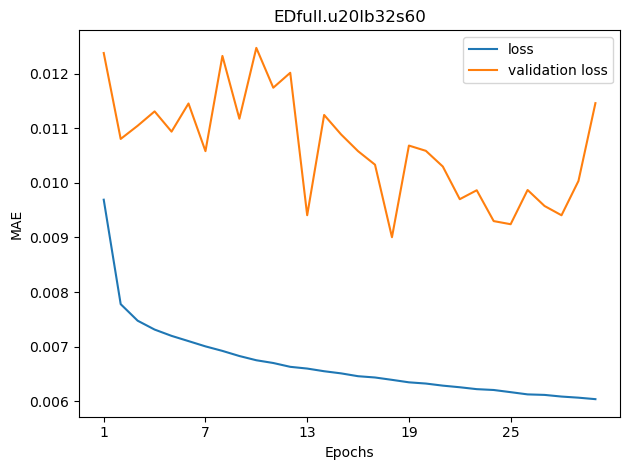

In [6]:
progress = pd.read_csv(experimento.model_path_log)
skip = 0

plt.plot([str(x) for x in range(1+skip,progress.shape[0]+1)], progress['loss'].iloc[skip:], label='loss')
plt.plot([str(x) for x in range(1+skip,progress.shape[0]+1)], progress['val_loss'].iloc[skip:], label='validation loss')
plt.title(f'{model_type}.u{n_units}lb{lookback}s{sampling}')
plt.xlabel('Epochs')
plt.ylabel('MAE')
if progress.shape[0]>10:
    plt.xticks([str(x) for x in range(1+skip,progress.shape[0],progress.shape[0]//5)])
plt.legend()
plt.tight_layout()
plt.show()

## Evaluación

In [10]:
experimento = experiment.ExperimentED(
    lookback=lookback,
    sampling=sampling,
    model_config=model_config,
    months=months, 
    airport=airport,
    features=feat_dict
)
experimento.load_model('best')

1337/1337 [==============================] - 19s 13ms/step
Val set           | MAE:        201.426s
                  | RMSE:       303.906s
                  | StDev:      289.710s
                  | Mean:        91.801s
                  | MAPE:         0.138
                  | Muestra:    171,112
1563/1563 [==============================] - 21s 13ms/step
Test set          | MAE:        200.679s
                  | RMSE:       308.966s
                  | StDev:      294.202s
                  | Mean:        94.370s
                  | MAPE:         0.146
                  | Muestra:    199,933


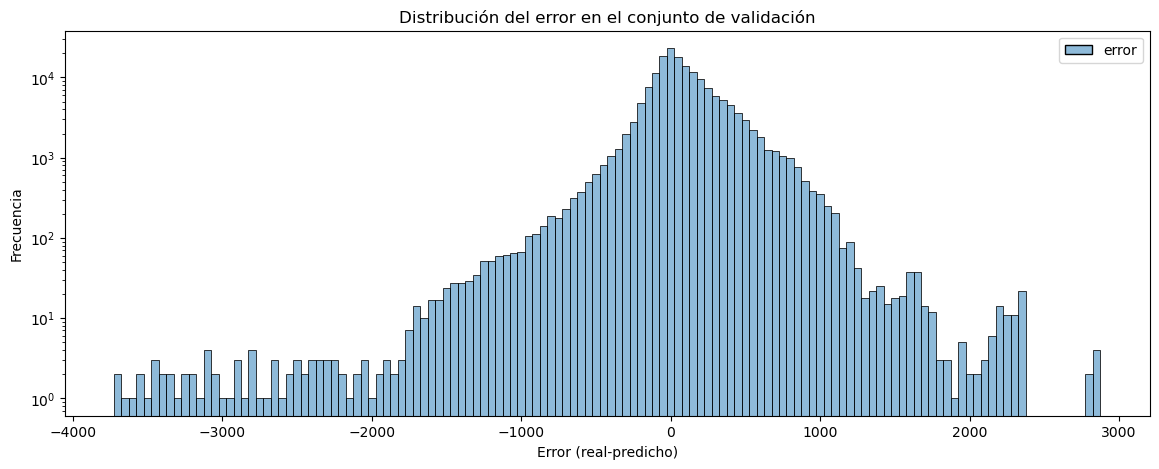

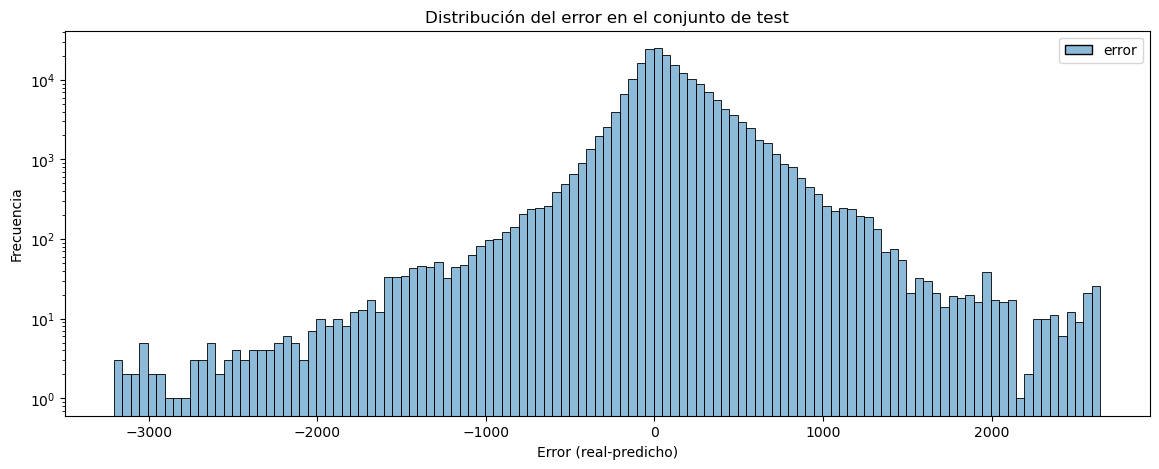

In [11]:
experimento.evaluate(from_parquet=from_parquet, print_err=True)

In [12]:
experimento.evaluate_at_times()

val: Finalizado                                                  
test: Finalizado                                                  


In [13]:
experimento.evaluate_airports()

(40/40)  Done.                                                    


## Generación de informe

In [ ]:
from rtaUtils.experiment import report_columns
report_df_long = pd.DataFrame.from_dict(
    experimento.results, orient='index',
    columns=['dataset','time',*report_columns])
report_df = report_df_long.pivot_table(index=['dataset'], columns=['time'], values=report_columns)
report_df.columns = [' '.join((str(y) for y in x)) 
                     for x in report_df.columns.to_flat_index()]
report_df = report_df.reset_index()
# report_df[[x for x in report_df.columns if report_columns[0] in x]]

In [ ]:
report_df

In [ ]:
report_df.to_csv(f'./results/{model_type}_s{sampling}_lb{lookback}_u{n_units}.csv', 
                 header=True, encoding='utf8')

## Visualización

In [ ]:
import plotly.express as px

In [ ]:
report_df = pd.read_csv(f'./results/{model_type}_s{sampling}_lb{lookback}_u{n_units}.csv', 
                        header=0, encoding='utf8', index_col=0)

In [ ]:
vis = pd.merge(
    report_df[['MAE all','RMSE all','MAPE all', 'StDev all','Mean all','dataset']],
    pd.read_csv('./data/airports.csv', sep = ','),
    left_on='dataset', right_on='id'
)

In [ ]:
td = data_loading.load_final_data(months, 'test')[['aerodromeOfDeparture', 'fpId']].drop_duplicates()\
              .groupby('aerodromeOfDeparture').count()

vis = pd.merge(vis, td, left_on='dataset', right_on='aerodromeOfDeparture')

In [ ]:
report_df

In [ ]:
px.scatter_mapbox(vis, 'lat', 'lon', zoom=3.6,width=950, height=750,
                  mapbox_style="open-street-map", opacity = 1,
                  color = 'MAE all', size='fpId',
#                   range_color=(50,300),
#                   color_continuous_scale='RdYlGn_r', #'bluered' 'Portland'
                  # color_continuous_midpoint=150,
                  hover_data = {'MAE all':':.3f',
                                'RMSE all':':.3f'},
                  hover_name='dataset'
                 )

In [ ]:
px.scatter_mapbox(vis, 'lat', 'lon', zoom=3.6,width=950, height=750,
                  mapbox_style="open-street-map", opacity = 1,
                  color = 'MAPE all', size='fpId',
                  # range_color=(0,0.2),
                  # color_continuous_scale='RdYlGn_r', #'bluered' 'Portland'
                  # color_continuous_midpoint=150,
                  hover_data = {'MAE all':':.3f',
                                'RMSE all':':.3f'},
                  hover_name='dataset'
                 )